Notebook for testing QSP sequences on quantum circuits.

Cambridge Consultants 2024\
Walden Killick

The purpose of this notebook is to demonstrate the integration of QSP pulse sequences generated by the pyqsp package with quantum circuits in Qiskit's formalism. I.e., to show how the pulse sequences are implemented on actual QSP and QSVT circuits.

See [Martyn et al.](https://arxiv.org/abs/2105.02859) for an overview of QSP.

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pyqsp
from pyqsp.angle_sequence import Polynomial, QuantumSignalProcessingPhases
from qiskit import QuantumCircuit
from qiskit.circuit.library.standard_gates import RXGate
from qiskit.quantum_info import Operator

The length of the angle sequence, and consequently query complexity, required for matrix inversion by QSVT depends on the condition number $\kappa$ of the matrix and on the desired accuracy $\varepsilon$. [Martyn et al.](https://arxiv.org/abs/2105.02859) show that we can perform matrix inversion with a query complexity of
$$
O(\kappa \log(\kappa / \varepsilon)).
$$

In [22]:
kappa = 3 # matrix condition number
epsilon = 0.1 # target accuracy

# Generate the polynomial which approximates (an appropriately scaled version of) 1/x.
pg = pyqsp.poly.PolyOneOverX()
pcoefs = pg.generate(kappa=kappa, epsilon=epsilon)
poly = Polynomial(pcoefs)

# Find the phase angles which implement the aforementioned polynomial.
ang_seq = QuantumSignalProcessingPhases(
    poly, signal_operator="Wx", method="laurent", measurement="x"
)

b=30, j0=14
[PolyOneOverX] minimum [-3.5325637] is at [-0.20530335]: normalizing
[PolyOneOverX] bounding to 0.5
[pyqsp.PolyOneOverX] pcoefs=[ 0.00000000e+00  4.24568213e+00  0.00000000e+00 -6.14813187e+01
  0.00000000e+00  5.70160728e+02  0.00000000e+00 -3.77110116e+03
  0.00000000e+00  1.86774294e+04  0.00000000e+00 -7.07245446e+04
  0.00000000e+00  2.06037512e+05  0.00000000e+00 -4.61025085e+05
  0.00000000e+00  7.86778785e+05  0.00000000e+00 -1.01130011e+06
  0.00000000e+00  9.59305607e+05  0.00000000e+00 -6.49556764e+05
  0.00000000e+00  2.96436030e+05  0.00000000e+00 -8.15921088e+04
  0.00000000e+00  1.02215704e+04]


In [23]:
def get_signal_response(
        amplitude: float,
        ang_seq: list[float],
        print_circuit: bool = False
        ) -> complex:
    """Compute the amplitude transformation enacted by a given QSP sequence.

    Parameters
    ----------
    amplitude : float
        Input amplitude. Equal to the top-left entry of an RX gate.
    ang_seq : list[float]
        QSP phase angle sequence.
    print_circuit : bool, optional
        Whether to print the QSVT circuit, by default False.

    Returns
    -------
    complex
        The amplitude after being transformed by the QSP sequence.
    """
    theta = -2*np.arccos(amplitude)
    signal_operator = RXGate(theta)

    qsvt_circuit = QuantumCircuit(1)
    qsvt_circuit.h(0)
    for angle in ang_seq[:-1]:
        qsvt_circuit.rz(2*angle, 0)
        qsvt_circuit.append(signal_operator, [0])
    qsvt_circuit.rz(2*ang_seq[-1], 0)
    qsvt_circuit.h(0)

    if print_circuit:
        print(qsvt_circuit)

    return Operator(qsvt_circuit).to_matrix()[0][0]

Example of the QSP circuit for a simple phase angle sequence:

In [24]:
get_signal_response(amplitude=0.1, ang_seq=[0, np.pi/4, 0], print_circuit=True)

   ┌───┐┌───────┐┌─────────────┐┌─────────┐┌─────────────┐┌───────┐┌───┐
q: ┤ H ├┤ Rz(0) ├┤ Rx(-2.9413) ├┤ Rz(π/2) ├┤ Rx(-2.9413) ├┤ Rz(0) ├┤ H ├
   └───┘└───────┘└─────────────┘└─────────┘└─────────────┘└───────┘└───┘


(-0.6929646455628165+0.1407124727947029j)

/tmp/ipykernel_54398/1342514984.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  y_target = [1/(2*kappa*amplitude) for amplitude in x]


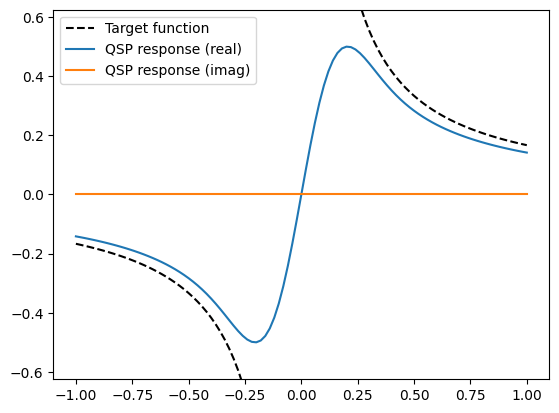

In [25]:
x = np.linspace(-1, 1, 101)
y_real = [get_signal_response(amplitude, ang_seq).real for amplitude in x]
y_imag = [get_signal_response(amplitude, ang_seq).imag for amplitude in x]
y_target = [1/(2*kappa*amplitude) for amplitude in x]

plt.plot(x, y_target, '--', label='Target function', color='black')
plt.plot(x, y_real, label='QSP response (real)')
plt.plot(x, y_imag, label='QSP response (imag)')
plt.legend()
plt.ylim(1.25*min(y_real), 1.25*max(y_real))
plt.show()